conda create --name applied_project numpy ipykernel jupyter pandas matplotlib ta conda-forge::scikit-learn anaconda::pandas-datareader

# Data Preparation
- Gold Features: Open, High, Low, Volume, Lagged Features, Returns, Price Changes
- Technical Features: MA, EMA, Bollinger Bands, RSI, MACD, ATR
- Macro Features: USD Index DXY, Crude Oil Index, Interest Rates, CPI, S&P 500 Index, VIX, Money Supply
- Categorical Features: Date, Month, Year, Day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Process Gold Features
df = pd.read_csv("Gold Futures Historical Data.csv")
print(df.columns)
print(df.shape)

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change'], dtype='object')
(4965, 7)


In [2]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y", errors='coerce')

# Make sure no NaT
missing_dates: int = df['date'].isna().sum()
print(missing_dates) # 0

# Sort by date, asc
df = df.sort_values('date').reset_index(drop=True)

# Create year, month and quarter columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter


0


In [3]:
# Fix variable data types - convert to numeric
# Remove final char from volume and change
df['volume'] = df['volume'].str[:-1]
df['change'] = df['change'].str[:-1]

# Remove commas and convert to float
df[["open", "price", "high", "low", "volume", "change"]] = df[["open", "price", "high", "low", "volume", "change"]].replace(',', '', regex=True).astype(float).round(2)
print(df.dtypes)

date       datetime64[ns]
price             float64
open              float64
high              float64
low               float64
volume            float64
change            float64
year                int32
month               int32
quarter             int32
dtype: object


## Target Definition

In [4]:
# Creating target variable - next day's binary price direction
df['target'] = (df['price'].shift(-5) > df['price']).astype(int)

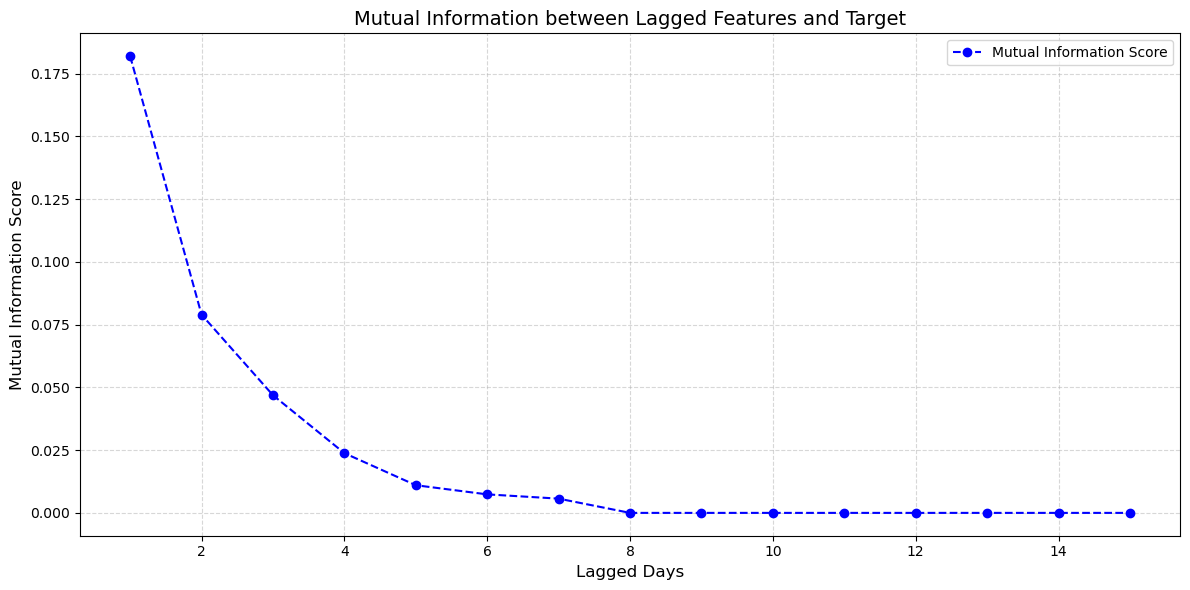

In [5]:
from sklearn.feature_selection import mutual_info_regression

# add lags we set in "lag_list" and place them in order to the dataset.
def Add_Lag(data,col,lag_list):
    position = data.columns.tolist().index(col)

    for lag in lag_list:
        col_val = data[col].shift(lag)
        col_name = col+'_lag:'+'{length}'.format(length=lag)
        data.insert(loc=position, column=col_name, value=col_val)
    return data

def mutual_information_lag(Data,col,n_lag,k_best):
    
    #create a dataset by selecting just one column from Gold dataset; a dataset with just one column of {Open,Close,High,Low,Volume} and time as index
    data = pd.DataFrame(Data[col])
    
    #create the dataset that its columns are lags with different shifts
    mic_df = Add_Lag(data,col,[i+1 for i in range(n_lag)])
    mic_ordered = {}
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for i in range(1,n_lag+1):
        
        i_lag = mic_df[mic_df.columns[mic_df.shape[1]-i-1]][i:]
        i_lag_name = mic_df.columns[mic_df.shape[1]-i-1]
        score = mutual_info_regression(np.array(i_lag).reshape(-1, 1), mic_df[col][i:])
        mic_ordered[i_lag_name] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_lags = list(sorted_mic.keys())[:k_best]
    
    #create a list of best k lags obtained above
    select_lag_num = []
    for i in selected_lags:
        
        pos = i.find(':')
        select_lag_num.append(int(i[pos+1:]))
        
    select_lag_num_sort = sorted(select_lag_num)
    
    #draw a plot that visualize all lags (not just best k lags) and their mutul information score with the target
    plt.figure(figsize=(12, 6))
    plt.plot([i+1 for i in range(n_lag)], list(sorted_mic.values()), '--bo', label="Mutual Information Score")
    plt.title("Mutual Information between Lagged Features and Target", fontsize=14)
    plt.xlabel("Lagged Days", fontsize=12)
    plt.ylabel("Mutual Information Score", fontsize=12)
    # plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return select_lag_num_sort,sorted_mic,selected_lags,sorted_mic.values()

best_lags = mutual_information_lag(df,'target',15,10)

In [6]:
# Visually, we can see lags 1 and 2 contain the most information
columns_to_lag = ['price', 'open', 'volume']

for col in columns_to_lag:
    for lag in [1,2]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

df.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'target', 'price_lag_1', 'price_lag_2',
       'open_lag_1', 'open_lag_2', 'volume_lag_1', 'volume_lag_2'],
      dtype='object')

## TA Technical Indicators:

Trend Indicators

Momentum Indicators

Volatility Indicators

In [7]:
# Add Technical Features
import ta

# Initialize ta features (adds automatically NaNs at the beginning)
# 1. Trend Indicators
df['SMA_10'] = ta.trend.SMAIndicator(close=df['price'], window=10).sma_indicator()
df['EMA_10'] = ta.trend.EMAIndicator(close=df['price'], window=10).ema_indicator()
macd = ta.trend.MACD(close=df['price'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# 2. Momentum Indicators
df['RSI'] = ta.momentum.RSIIndicator(close=df['price'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['price'])
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

# 3. Volatility Indicators
boll = ta.volatility.BollingerBands(close=df['price'], window=20, window_dev=2)
df['BB_upper'] = boll.bollinger_hband()
df['BB_lower'] = boll.bollinger_lband()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['price']).average_true_range()

df.dropna(inplace=True)  # Drop rows with NaN values after adding indicators

In [8]:
df.head()

,date,price,open,high,low,volume,change,year,month,quarter,...,MACD,MACD_signal,MACD_diff,RSI,Stoch_K,Stoch_D,BB_upper,BB_lower,BB_width,ATR
33,2006-02-21,556.6,557.7,559.5,553.9,42.09,0.36,2006,2,1,...,0.126940,1.941141,-1.814202,51.353616,45.083933,37.250200,581.568850,539.031150,42.537701,11.804005
34,2006-02-22,556.6,556.9,557.7,549.8,45.84,0.00,2006,2,1,...,0.266040,1.606121,-1.340081,51.353616,45.083933,43.485212,581.534892,538.915108,42.619784,11.525147
35,2006-02-23,550.9,556.1,558.4,550.3,42.15,-1.02,2006,2,1,...,-0.082711,1.268355,-1.351066,47.672348,32.587065,40.918310,581.304222,537.985778,43.318444,11.280494
36,2006-02-24,561.2,551.5,562.0,549.6,58.72,1.87,2006,2,1,...,0.466646,1.108013,-0.641367,54.078400,58.208955,45.293318,581.379693,538.040307,43.339386,11.360459
37,2006-02-27,557.0,561.0,561.7,554.8,35.16,-0.75,2006,2,1,...,0.556693,0.997749,-0.441056,51.319486,51.752022,47.516014,581.318995,537.921005,43.397991,11.041854


## Macro Features
- USD Index (Yahoo Finance DXY)
- Crude Oil Prices (Yahoo Finance CL=F)
- Stock Market Index (S&P 500 ^GSPC)  
- Volatility Index (VIX ^VIX)

In [9]:
from pandas_datareader import data as pdr

start_date = '2006-03-01'
end_date = '2025-07-01'

# Define macro tickers for FRED data
fred_series = {
    'dxy': 'DTWEXBGS',         # Trade-Weighted U.S. Dollar Index
    'oil': 'DCOILWTICO',       # Crude Oil Prices (WTI)
    'vix': 'VIXCLS',           # CBOE Volatility Index
    'us10y': 'DGS10',          # 10-Year Treasury Yield
    'cpius': 'CPIAUCSL'        # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
}

macro_df = pd.DataFrame()

# Download Adjusted Close prices
for name, code in fred_series.items():
    series = pdr.DataReader(code, 'fred', start_date, end_date)
    series.rename(columns={code: name}, inplace=True)
    if macro_df.empty:
        macro_df = series
    else:
        macro_df = macro_df.join(series, how='outer')

# Forward-fill CPI values within each month
macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')

macro_df

C:\Users\marty\AppData\Local\Temp\ipykernel_28420\2920327055.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')


,dxy,oil,vix,us10y,cpius
DATE,,,,,
2006-03-01,99.8355,62.01,11.54,4.59,199.7
2006-03-02,99.5969,63.36,11.72,4.64,199.7
2006-03-03,99.7024,63.61,11.96,4.68,199.7
2006-03-06,99.9834,62.46,12.74,4.74,199.7
2006-03-07,100.5640,61.51,12.66,4.74,199.7
...,...,...,...,...,...
2025-06-25,120.7333,65.98,16.76,4.29,321.5
2025-06-26,120.0587,66.44,16.59,4.26,321.5
2025-06-27,120.0786,66.66,16.32,4.29,321.5


In [10]:
# Obtain S&P 500 data from spreadsheet
sp500 = pd.read_csv("S&P 500 Historical Data.csv")
sp500.rename(columns={'Date': 'date', 'Price': 'sp500'}, inplace=True)

# Convert date column to datetime
sp500['date'] = pd.to_datetime(sp500['date'])

# Clean numeric values (remove commas, % if present)
sp500['sp500'] = sp500['sp500'].astype(str).str.replace(',', '')
sp500['sp500'] = pd.to_numeric(sp500['sp500'], errors='coerce')

# Keep only date and close price
sp500 = sp500[['date', 'sp500']]
sp500.sort_values('date', inplace=True)

In [11]:
# Merge with your gold DataFrame
df = df.merge(sp500, on='date', how='left')

# Merge macro data with gold dataframe
# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])
macro_df = macro_df.reset_index().rename(columns={'DATE': 'date'})

# Merge
df = df.merge(macro_df, on='date', how='left')

# Calculate percentage changes for macro features
macro_cols = ['dxy', 'oil', 'sp500', 'vix', 'us10y']
for col in macro_cols:
    df[f'{col}_pct_change'] = df[col].pct_change(fill_method=None)

# Drop missing rows
df.sort_values('date', inplace=True)
df.dropna(inplace=True)
df.set_index('date', inplace=True)


In [12]:
df.head()

,price,open,high,low,volume,change,year,month,quarter,target,...,dxy,oil,vix,us10y,cpius,dxy_pct_change,oil_pct_change,sp500_pct_change,vix_pct_change,us10y_pct_change
date,,,,,,,,,,,,,,,,,,,,,
2006-03-02,570.4,565.6,570.8,563.7,49.55,0.81,2006,3,1,0,...,99.5969,63.36,11.72,4.64,199.7,-0.002390,0.021771,-0.001626,0.015598,0.010893
2006-03-03,568.0,570.6,572.5,566.2,44.15,-0.42,2006,3,1,0,...,99.7024,63.61,11.96,4.68,199.7,0.001059,0.003946,-0.001474,0.020478,0.008621
2006-03-06,556.8,567.5,570.2,553.5,64.52,-1.97,2006,3,1,0,...,99.9834,62.46,12.74,4.74,199.7,0.002818,-0.018079,-0.006914,0.065217,0.012821
2006-03-07,554.5,556.5,559.8,549.6,72.67,-0.41,2006,3,1,0,...,100.5640,61.51,12.66,4.74,199.7,0.005807,-0.015210,-0.001877,-0.006279,0.000000
2006-03-08,544.3,554.0,555.4,539.5,89.86,-1.84,2006,3,1,1,...,100.8565,60.06,12.32,4.73,199.7,0.002909,-0.023573,0.002038,-0.026856,-0.002110


In [13]:
df.columns

Index(['price', 'open', 'high', 'low', 'volume', 'change', 'year', 'month',
       'quarter', 'target', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2', 'SMA_10', 'EMA_10',
       'MACD', 'MACD_signal', 'MACD_diff', 'RSI', 'Stoch_K', 'Stoch_D',
       'BB_upper', 'BB_lower', 'BB_width', 'ATR', 'sp500', 'dxy', 'oil', 'vix',
       'us10y', 'cpius', 'dxy_pct_change', 'oil_pct_change',
       'sp500_pct_change', 'vix_pct_change', 'us10y_pct_change'],
      dtype='object')

## Data Analysis

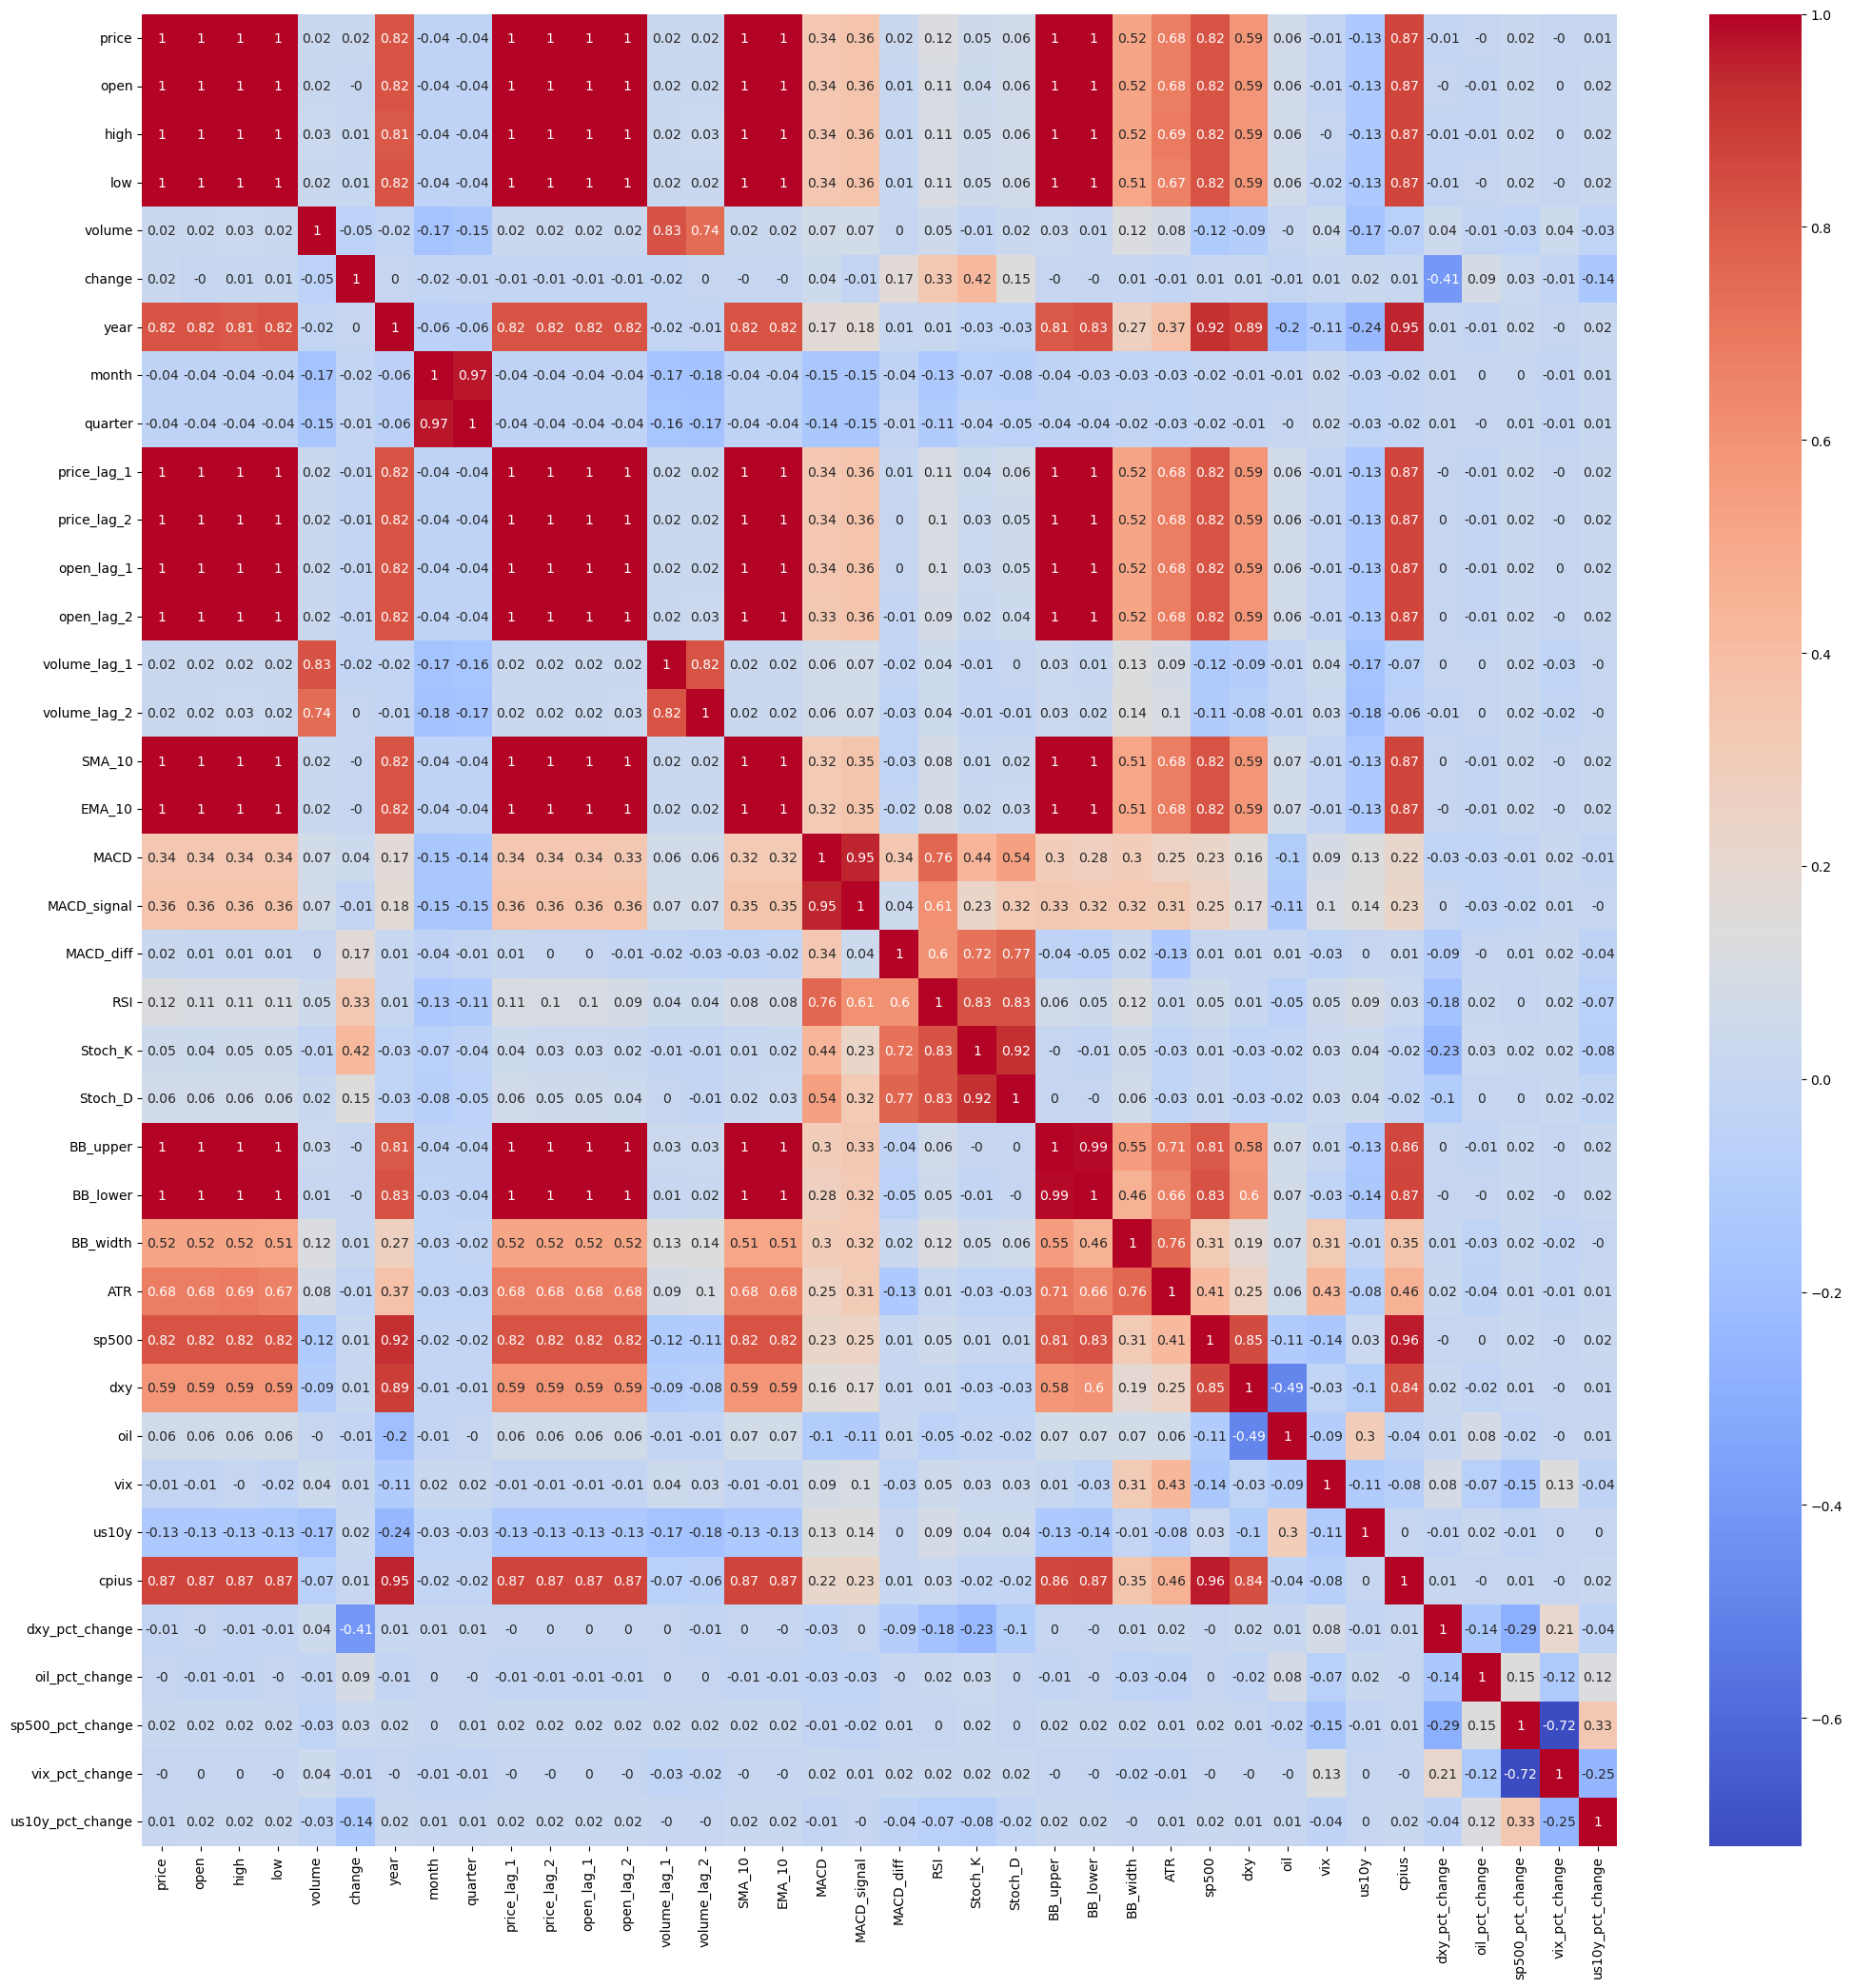

In [14]:
import seaborn as sns

df_no_target = df.drop(columns=['target'])
corr = round(df_no_target.corr(numeric_only=True),2)
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

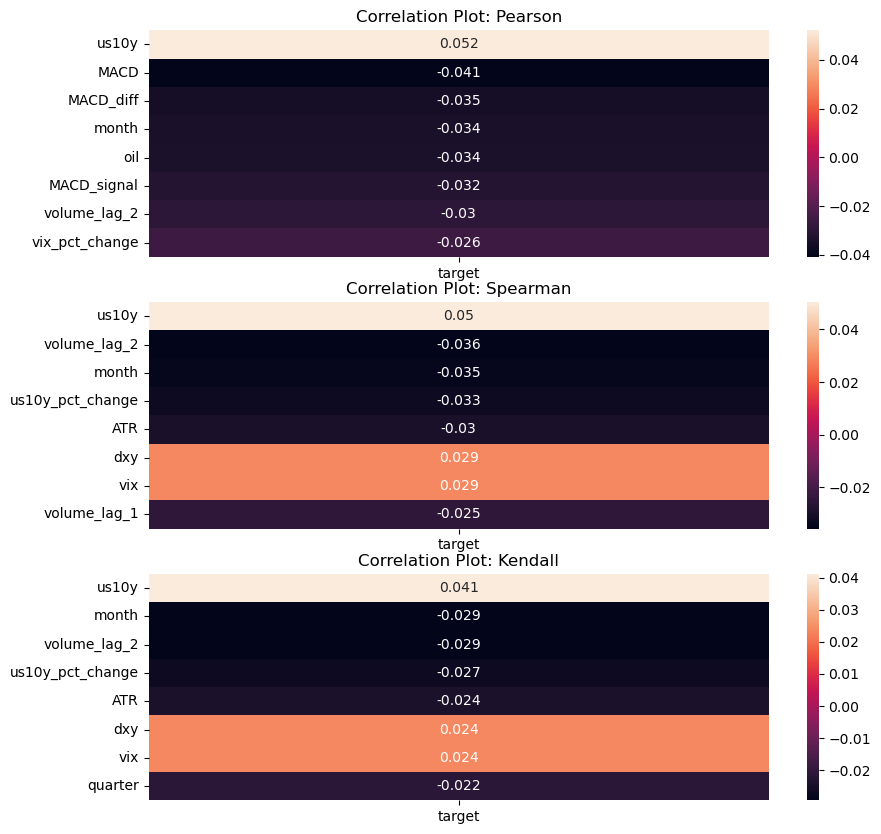

In [15]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))
## Correlation coefficient using different methods
# corr1 = df.corr('pearson')[['target']].sort_values(by='target', ascending=False, )
# corr2 = df.corr('spearman')[['target']].sort_values(by='target', ascending=False)
# corr3 = df.corr('kendall')[['target']].sort_values(by='target', ascending=False)

def get_corr(df, method, target_col='target', top_n=5):
    corr = df.corr(method=method)[[target_col]]
    corr = corr.drop(index=target_col)  # Drop self-correlation
    corr['abs'] = corr[target_col].abs()
    corr_sorted = corr.sort_values(by='abs', ascending=False)
    
    top_corr = corr_sorted.iloc[:top_n][[target_col]]
    
    return top_corr

corr1 = get_corr(df, 'pearson', 'target', 8)
corr2 = get_corr(df, 'spearman', 'target', 8)
corr3 = get_corr(df, 'kendall', 'target', 8)

corr1 = corr1[0:8]
corr2 = corr2[0:8]
corr3 = corr3[0:8]
#setting titles for each plot
ax[0].set_title('Correlation Plot: Pearson')
ax[1].set_title('Correlation Plot: Spearman')
ax[2].set_title('Correlation Plot: Kendall')
## Generating heatmaps of each methods
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.show()

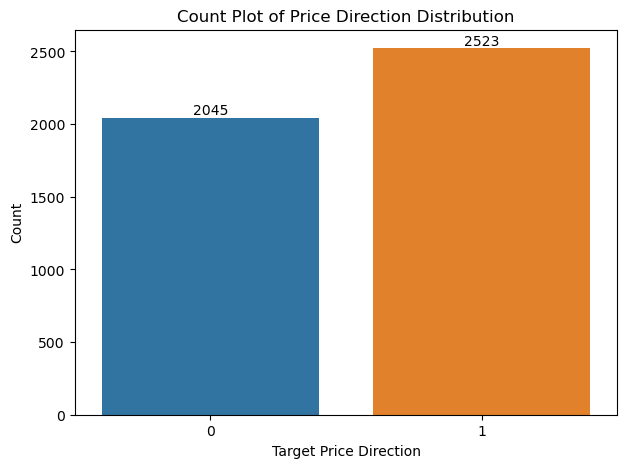

In [16]:
# Plot Training Set Distribution
plt.figure(figsize=(7,5))
ax = sns.countplot(x="target", hue='target', data=df, legend=False)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count Plot of Price Direction Distribution')
plt.xlabel('Target Price Direction')
plt.ylabel('Count')
plt.show()

In [17]:
# Define your feature groups

market_features = ['price', 'open', 'high', 'low', 'volume', 'change', 'year', 'month',
       'quarter', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2']

macro_features = ['sp500', 'dxy', 'oil', 'vix', 'us10y', 'cpius',
                  'dxy_pct_change', 'oil_pct_change', 'sp500_pct_change',
                  'vix_pct_change', 'us10y_pct_change']

technical_features = ['SMA_10', 'EMA_10', 'MACD', 'MACD_signal', 'MACD_diff',
                      'RSI', 'Stoch_K', 'Stoch_D', 'BB_upper', 'BB_lower',
                      'BB_width', 'ATR']

# Function to plot boxplots
def plot_feature_boxplots(features, title):
    n_cols = 4
    n_rows = int(np.ceil(len(features) / n_cols))
    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    
    for i, col in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x='target', y=col, data=df, hue="target") 
        plt.title(f'{col} vs Target')
        plt.xlabel('Target')
        plt.ylabel(col)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot technical features
# plot_feature_boxplots(technical_features, "Boxplots of Technical Features by Target")

# Plot macroeconomic features
# plot_feature_boxplots(macro_features, "Boxplots of Macroeconomic Features by Target")

# Plot market features
# plot_feature_boxplots(market_features, "Boxplots of Market Features by Target")

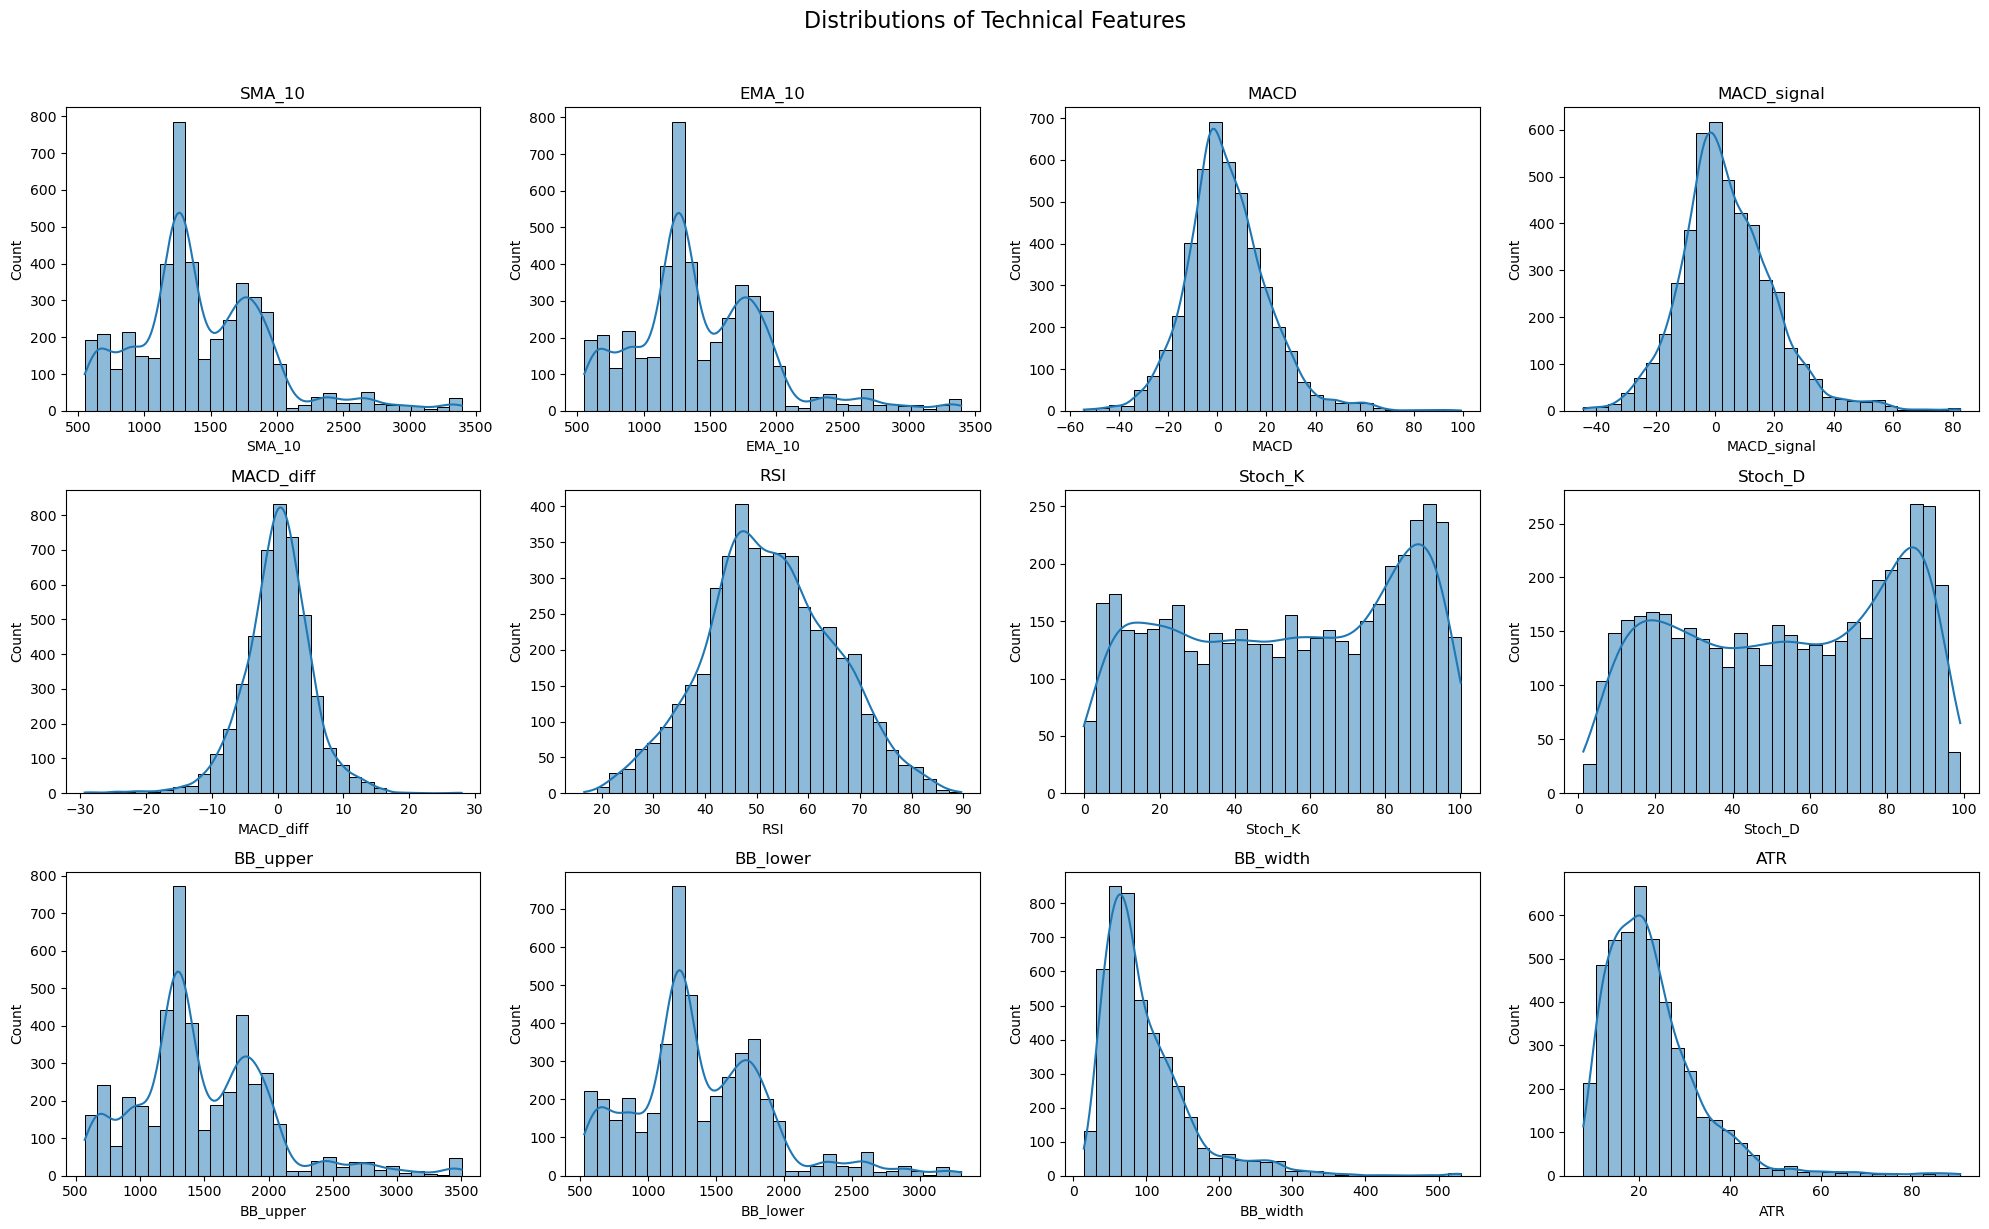

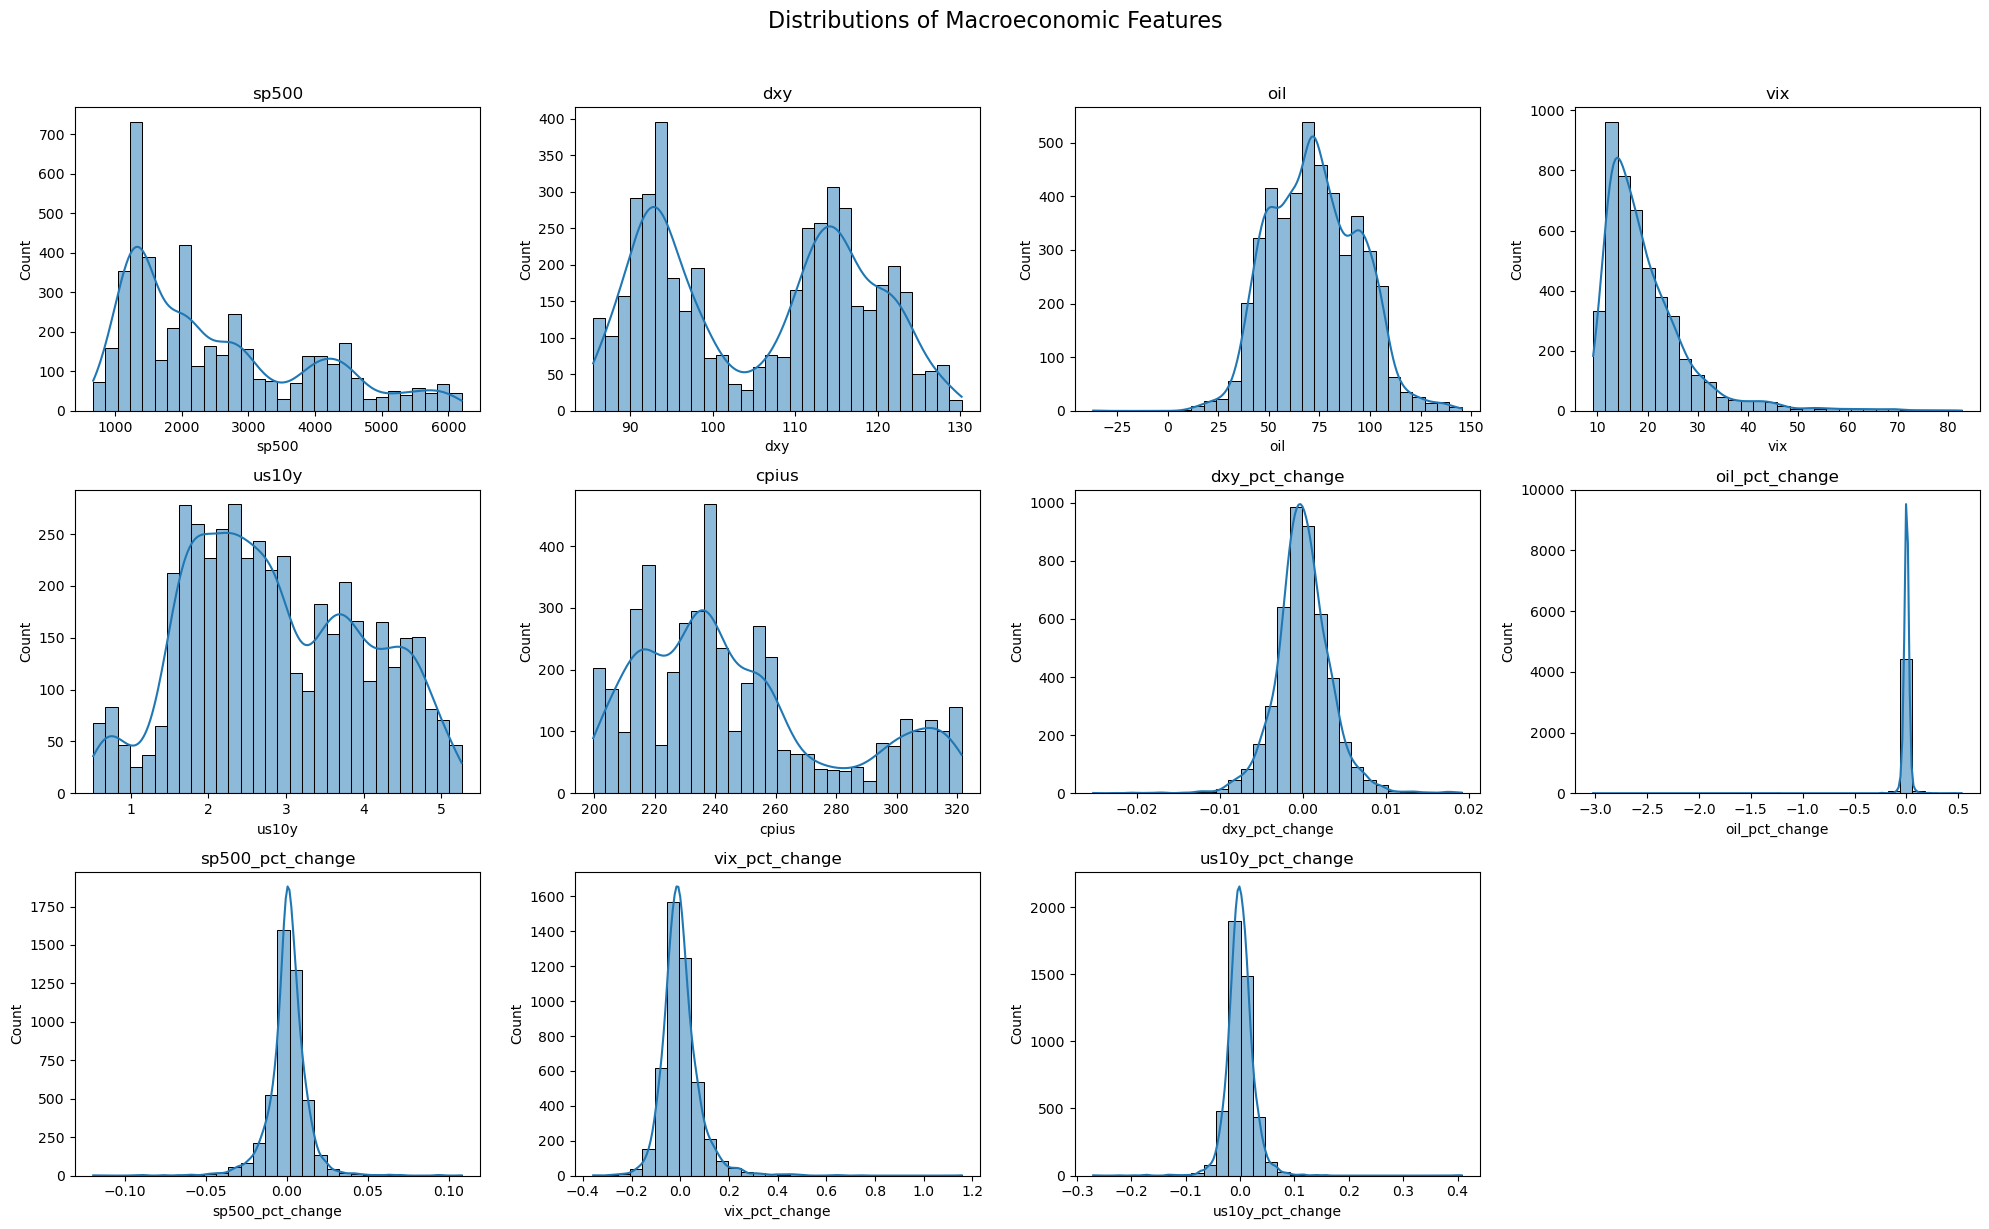

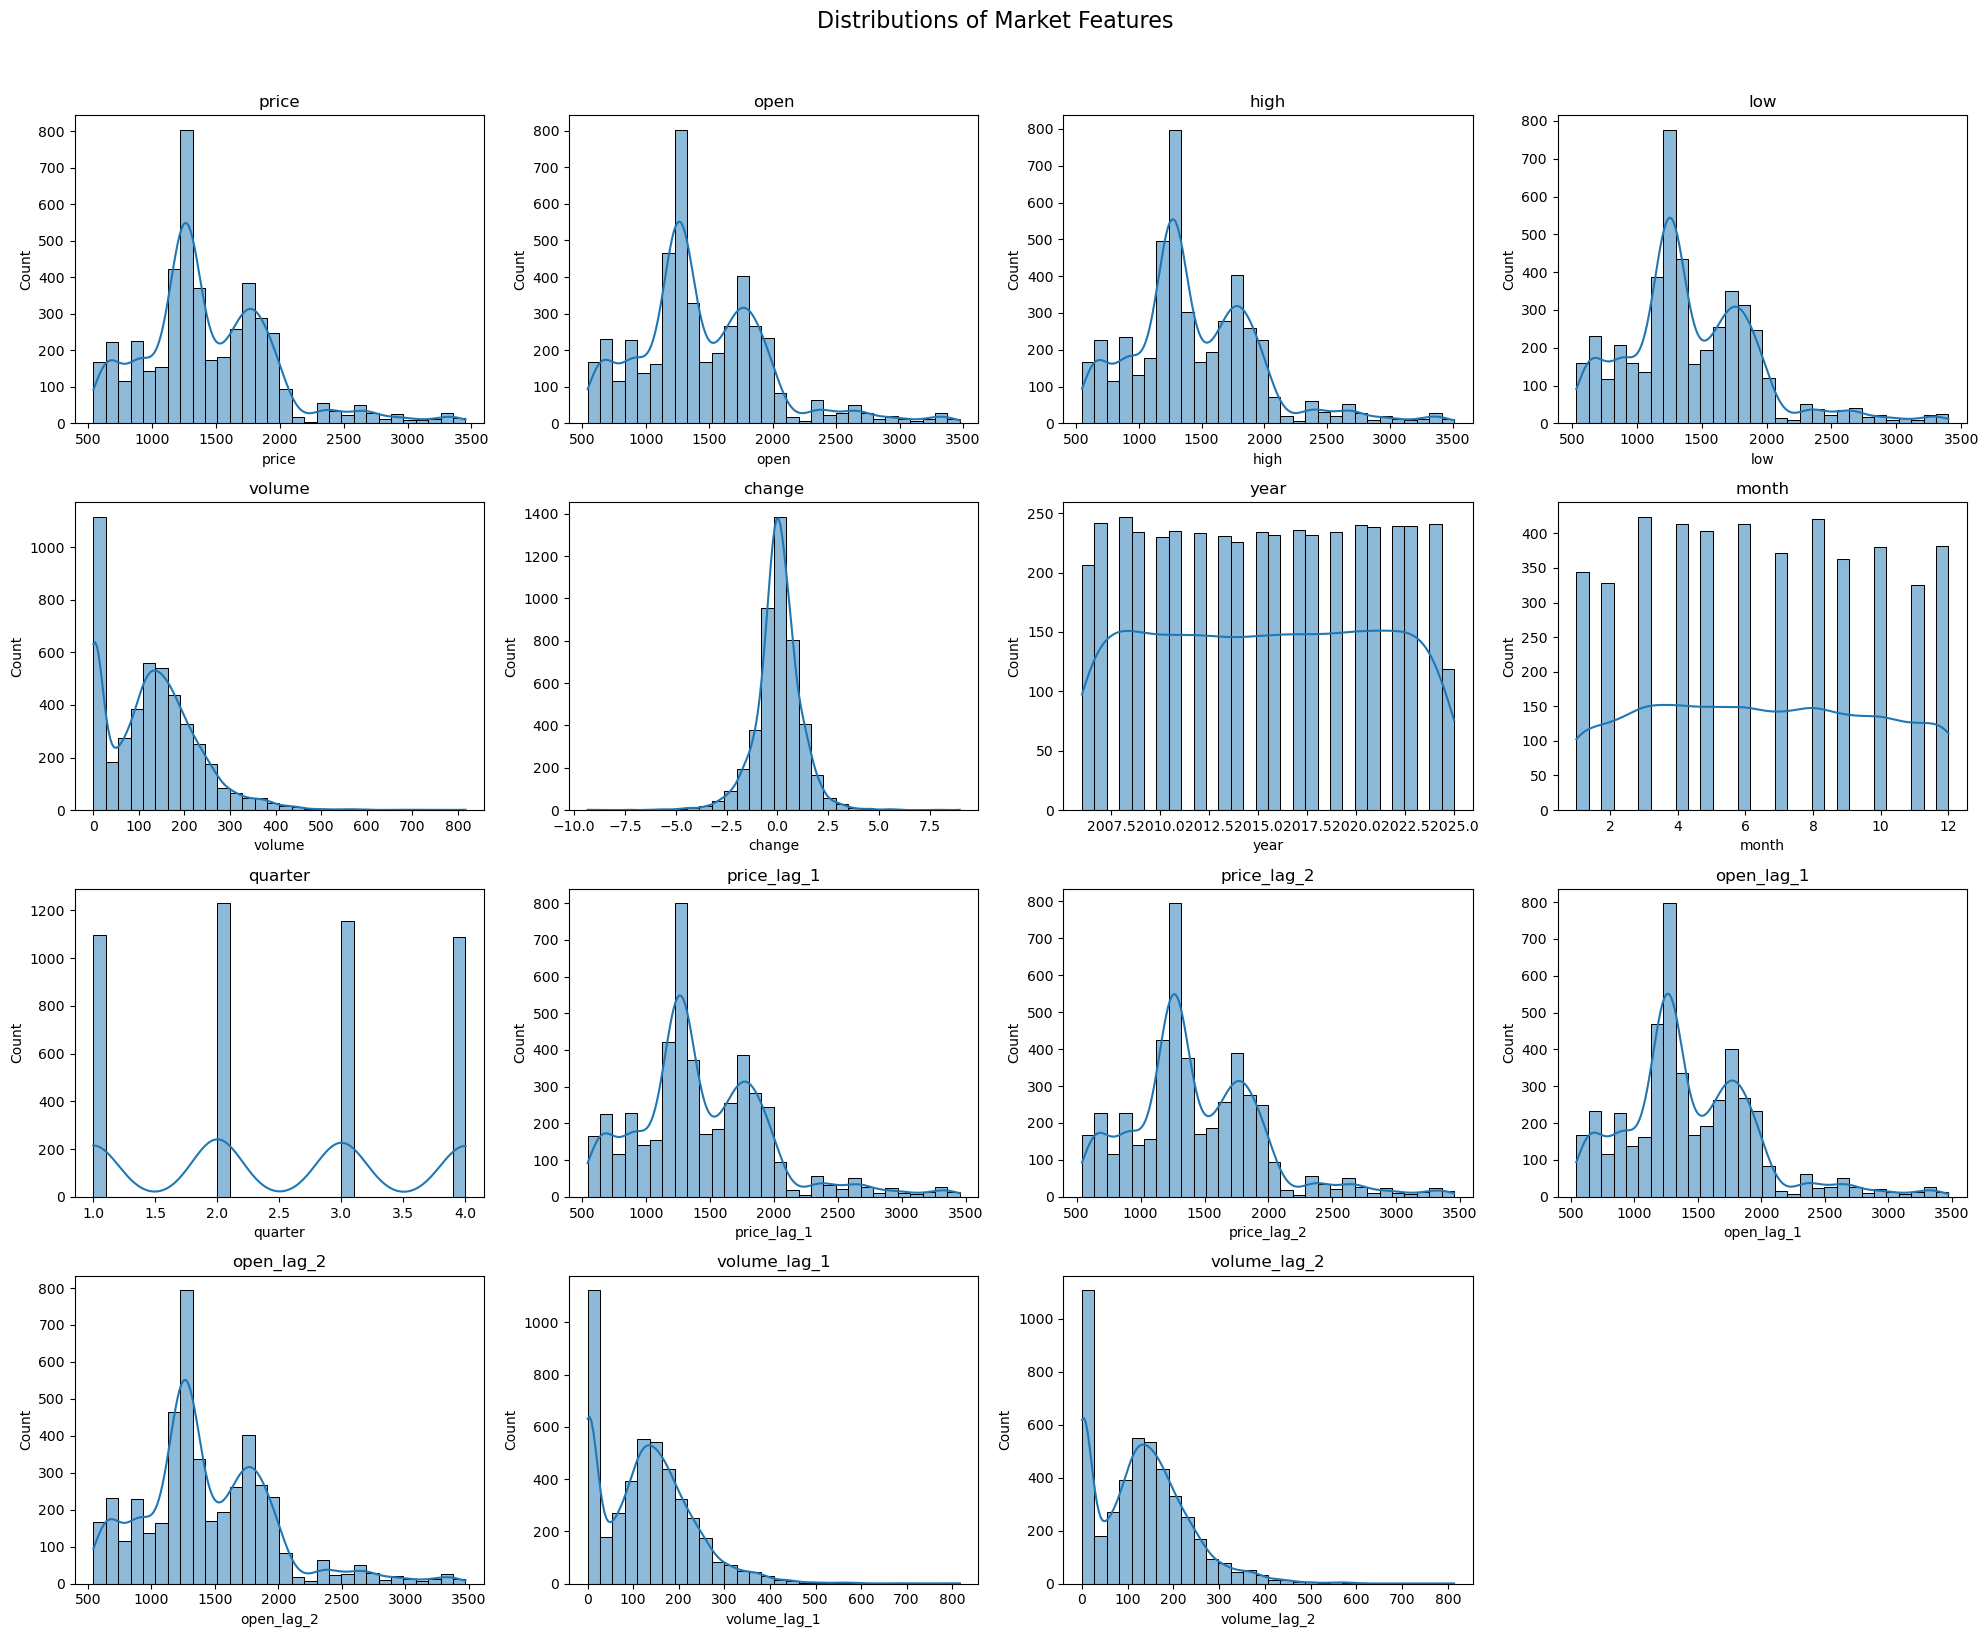

In [18]:
def plot_feature_distributions(features, data, title='Feature Distributions'):
    n_cols = 4
    n_rows = int(np.ceil(len(features) / n_cols))
    plt.figure(figsize=(n_cols * 5, n_rows * 4))

    for i, col in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(col)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_feature_distributions(technical_features, df, "Distributions of Technical Features")
plot_feature_distributions(macro_features, df, "Distributions of Macroeconomic Features")
plot_feature_distributions(market_features, df, "Distributions of Market Features")

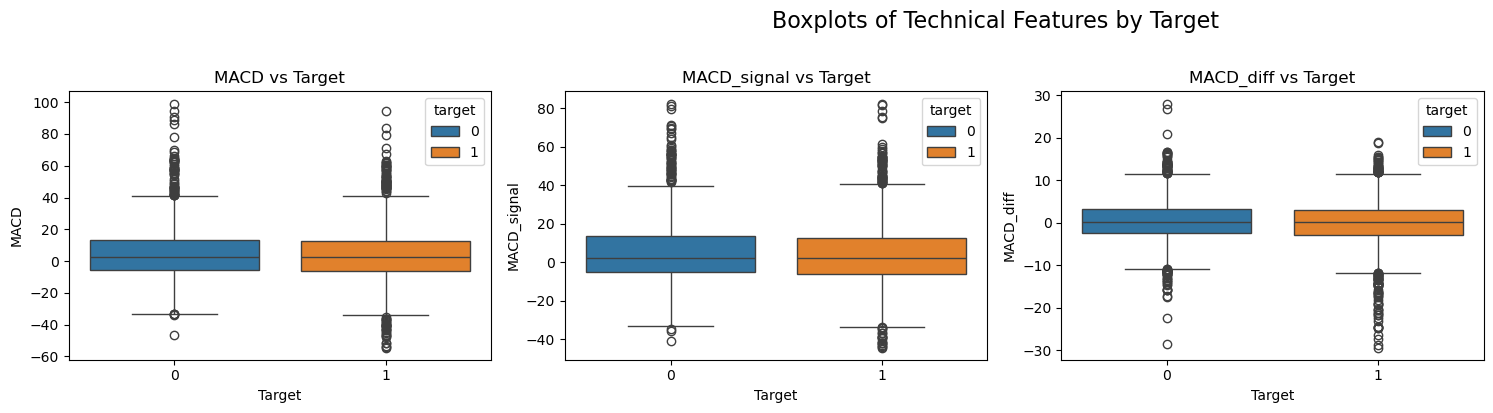

In [19]:
# Significant technical features
technical_features = ['SMA_10', 'EMA_10', 'MACD', 'MACD_signal', 'MACD_diff',
                      'RSI', 'Stoch_K', 'Stoch_D', 'BB_upper', 'BB_lower',
                      'BB_width', 'ATR']
best_technical_features = ['MACD', 'MACD_signal', 'MACD_diff']
best_macro_features = ['vix','dxy','us10y']
    
plot_feature_boxplots(best_technical_features, "Boxplots of Technical Features by Target")

# plot_feature_boxplots(best_macro_features, "Boxplots of Macroeconomic Features by Target")

## Split Dataset

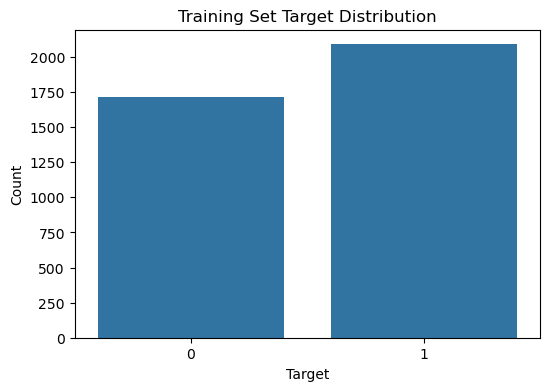

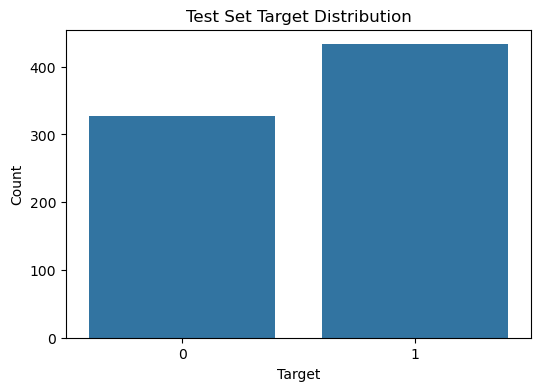

In [20]:
from sklearn.model_selection import TimeSeriesSplit

feature_columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2', 'SMA_10', 'EMA_10',
       'MACD', 'MACD_signal', 'MACD_diff', 'RSI', 'Stoch_K', 'Stoch_D',
       'BB_upper', 'BB_lower', 'BB_width', 'ATR', 'sp500', 'dxy', 'oil', 'vix',
       'us10y', 'cpius', 'dxy_pct_change', 'oil_pct_change',
       'sp500_pct_change', 'vix_pct_change', 'us10y_pct_change']

X = df.drop(labels=['target'], axis=1)
y = df['target']

tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train_full, X_test_final= X.iloc[train_index, :], X.iloc[test_index,:]
    y_train_full, y_test_final = y.iloc[train_index], y.iloc[test_index]

# Plot Training Set Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_full)
plt.title('Training Set Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Plot Test Set Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_test_final)
plt.title('Test Set Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

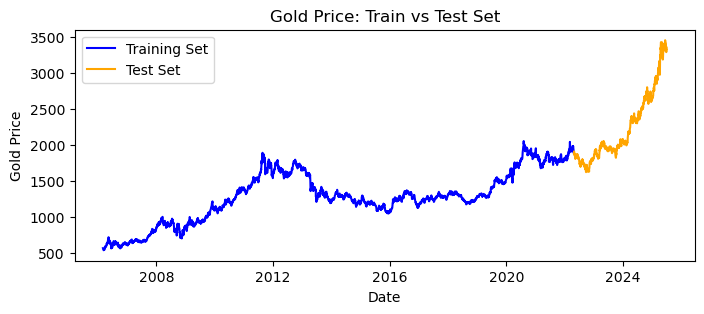

In [52]:
# Get train/test date ranges
train_dates = X_train_full.index
test_dates = X_test_final.index

plt.figure(figsize=(8,3))
plt.plot(df.loc[train_dates, 'price'], label='Training Set', color='blue')
plt.plot(df.loc[test_dates, 'price'], label='Test Set', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price: Train vs Test Set')
plt.legend()
plt.show()

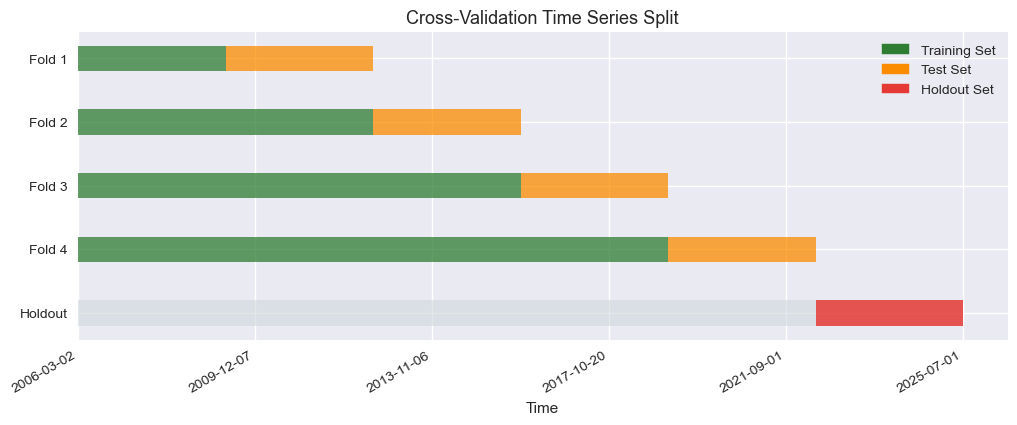

<Figure size 1500x500 with 0 Axes>

In [85]:
import matplotlib.patches as mpatches

# Collect all splits first
splits = list(tss.split(X))
n = len(splits)

fig, ax = plt.subplots(figsize=(12, 2 + 0.4 * n))
y_pos = np.arange(n)[::-1]  # top row = first fold
height = 0.4

for i, (train_idx, test_idx) in enumerate(splits):
    if i < n - 1:
        # CV folds: plot train (green) + validation (orange)
        ax.barh(y_pos[i],
                width=len(train_idx),
                left=train_idx[0],
                height=height,
                color="#2e7d32", alpha=0.75)  # train
        ax.barh(y_pos[i],
                width=len(test_idx),
                left=test_idx[0],
                height=height,
                color="#fb8c00", alpha=0.75)  # validation
    else:
        # Final split: present only the holdout (red), optional faint train context
        ax.barh(y_pos[i],
                width=len(train_idx),
                left=train_idx[0],
                height=height,
                color="#cfd8dc", alpha=0.6)   # optional context for train
        ax.barh(y_pos[i],
                width=len(test_idx),
                left=test_idx[0],
                height=height,
                color="#e53935", alpha=0.85)  # holdout

# Labels
labels = [f"Fold {i+1}" for i in range(n-1)] + ["Holdout"]
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel("Time")
ax.set_title("Cross-Validation Time Series Split", fontsize=13)

# If index is datetime, show date ticks
if np.issubdtype(X.index.dtype, np.datetime64):
    ticks = np.linspace(0, len(X) - 1, num=6, dtype=int)
    ax.set_xticks(ticks)
    ax.set_xticklabels([X.index[i].strftime("%Y-%m-%d") for i in ticks],
                       rotation=30, ha='right')
else:
    ax.set_xlabel("Index Position")
training_legend = mpatches.Patch(color="#2e7d32", label='Training Set')
test_legend = mpatches.Patch(color="#fb8c00", label='Test Set')
holdout_legend = mpatches.Patch(color="#e53935", label='Holdout Set')
plt.legend(handles=[training_legend, test_legend, holdout_legend])
plt.figure(figsize=(15,5))
plt.tight_layout()
plt.show()

In [47]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Define the model parameters lists for hyperparameter tuning
param_grids = {
    'log_reg': {'model__C': [0.01, 0.03, 0.05, 0.1]},
    'rf': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 10]},
    'ada': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.5, 1.0]},
    'xgb': {'model__n_estimators': [200, 400], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1]},
    'lgb': {'model__n_estimators': [200, 400], 'model__max_depth': [-1, 5], 'model__learning_rate': [0.01, 0.1]},
    'gbdt': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5], 'model__learning_rate': [0.05, 0.1]}
}

# Fixed Random State
STATE = 42

# Pipeline Creation
pipelines = {
    'log_reg': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2'))
    ]),
    'gbdt': Pipeline([
        ('model', GradientBoostingClassifier(random_state=STATE))
    ]),
    'rf': Pipeline([
        ('model', RandomForestClassifier(random_state=STATE))
    ]),
    'xgb': Pipeline([
        ('model', xgb.XGBClassifier(eval_metric='logloss', random_state=STATE))
    ]),
    'lgb': Pipeline([
        ('model', lgb.LGBMClassifier(random_state=STATE, verbose=-1))
    ]),
    'ada': Pipeline([
        ('model', AdaBoostClassifier(random_state=STATE))
    ])
}

In [48]:
tss = TimeSeriesSplit(n_splits=5)
metrics_summary = []
best_models = {}
best_params = {}   # Dictionary to store best hyperparameters

for name, pipe in pipelines.items():
    print(f"\nTuning and evaluating {name}...")
    grid = GridSearchCV(pipe, param_grids[name], cv=tss, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_full, y_train_full)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    best_params[name] = grid.best_params_ 

    # Cross-validated training metrics
    train_scores = []
    for train_idx, val_idx in tss.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        best_model.fit(X_train, y_train)
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val)[:,1]

        train_scores.append([
            accuracy_score(y_val, y_val_pred),
            precision_score(y_val, y_val_pred),
            recall_score(y_val, y_val_pred),
            f1_score(y_val, y_val_pred),
            roc_auc_score(y_val, y_val_proba)
        ])

    train_scores = np.array(train_scores)
    train_metrics = train_scores.mean(axis=0)

    # Final test metrics on last 20%
    best_model.fit(X_train_full, y_train_full)
    y_test_pred = best_model.predict(X_test_final)
    y_test_proba = best_model.predict_proba(X_test_final)[:,1]

    test_metrics = [
        accuracy_score(y_test_final, y_test_pred),
        precision_score(y_test_final, y_test_pred),
        recall_score(y_test_final, y_test_pred),
        f1_score(y_test_final, y_test_pred),
        roc_auc_score(y_test_final, y_test_proba)
    ]

    metrics_summary.append({
        'Model': name,
        'CV Accuracy': train_metrics[0],
        'CV Precision': train_metrics[1],
        'CV Recall': train_metrics[2],
        'CV F1': train_metrics[3],
        'CV ROC-AUC': train_metrics[4],
        'Test Accuracy': test_metrics[0],
        'Test Precision': test_metrics[1],
        'Test Recall': test_metrics[2],
        'Test F1': test_metrics[3],
        'Test ROC-AUC': test_metrics[4]
    })

metrics_df = pd.DataFrame(metrics_summary)

# Print the best hyperparameters for each model
print("\nBest Hyperparameters for Each Model:")
for model, params in best_params.items():
    print(f"{model}: {params}")

# Show both metrics and hyperparameters
print("\nCross-Validated Training Metrics and Final Test Metrics:")
print(metrics_df)




Tuning and evaluating log_reg...

Tuning and evaluating gbdt...

Tuning and evaluating rf...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Tuning and evaluating xgb...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Tuning and evaluating lgb...

Tuning and evaluating ada...


c:\Programming\Resources\miniconda3\envs\applied_project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Best Hyperparameters for Each Model:
log_reg: {'model__C': 0.05}
gbdt: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
rf: {'model__max_depth': 10, 'model__n_estimators': 100}
xgb: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
lgb: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
ada: {'model__learning_rate': 1.0, 'model__n_estimators': 200}

Cross-Validated Training Metrics and Final Test Metrics:
     Model  CV Accuracy  CV Precision  CV Recall     CV F1  CV ROC-AUC  \
0  log_reg     0.471924      0.567505   0.254088  0.269920    0.519519   
1     gbdt     0.474132      0.651487   0.351127  0.340601    0.525117   
2       rf     0.505678      0.457453   0.458210  0.428009    0.521182   
3      xgb     0.497476      0.436321   0.541239  0.474390    0.515205   
4      lgb     0.483596      0.546330   0.453040  0.435397    0.498617   
5      ada     0.466877      0.419826   0.312238  0.3

In [86]:
# Identify best model based on Test F1 or ROC-AUC
best_model_index = metrics_df['Test F1'].idxmax()
best_model_name = metrics_df.iloc[best_model_index]["Model"]
final_model = best_models[best_model_name]
final_params = best_params[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Best hyperparameters: {final_params}")

# Retrain on full training data
final_model.fit(X_train_full, y_train_full)

# Get probabilities on the test set
y_train_proba = final_model.predict_proba(X_train_full)[:, 1]
y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Threshold range
thresholds = np.arange(0.35, 0.71, 0.01) 

metrics_list = []

for t in thresholds:
    y_pred_thresh = (y_test_proba >= t).astype(int)
    prec = precision_score(y_test_final, y_pred_thresh)
    rec = recall_score(y_test_final, y_pred_thresh)
    f1 = f1_score(y_test_final, y_pred_thresh)
    roc_auc = roc_auc_score(y_test_final, y_pred_thresh)

    metrics_list.append({
        'Threshold': round(t, 2),
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
    })

# Convert to DataFrame
threshold_metrics_df = pd.DataFrame(metrics_list)

print(threshold_metrics_df)
best_threshold = threshold_metrics_df.loc[threshold_metrics_df['F1'].idxmax(), 'Threshold']
print(f"\nOptimal Threshold: {best_threshold}")


Best model: log_reg
Best hyperparameters: {'model__C': 0.05}
    Threshold  Precision    Recall        F1
0        0.35   0.573222  0.949192  0.714783
1        0.36   0.575246  0.944573  0.715035
2        0.37   0.577904  0.942263  0.716418
3        0.38   0.576758  0.928406  0.711504
4        0.39   0.578792  0.907621  0.706835
5        0.40   0.581465  0.898383  0.705989
6        0.41   0.576687  0.868360  0.693088
7        0.42   0.570747  0.829099  0.676083
8        0.43   0.569787  0.801386  0.666027
9        0.44   0.564626  0.766744  0.650343
10       0.45   0.557726  0.725173  0.630522
11       0.46   0.557621  0.692841  0.617920
12       0.47   0.552734  0.653580  0.598942
13       0.48   0.547131  0.616628  0.579805
14       0.49   0.547414  0.586605  0.566332
15       0.50   0.547945  0.554273  0.551091
16       0.51   0.546135  0.505774  0.525180
17       0.52   0.551913  0.466513  0.505632
18       0.53   0.569733  0.443418  0.498701
19       0.54   0.583062  0.413395  0.

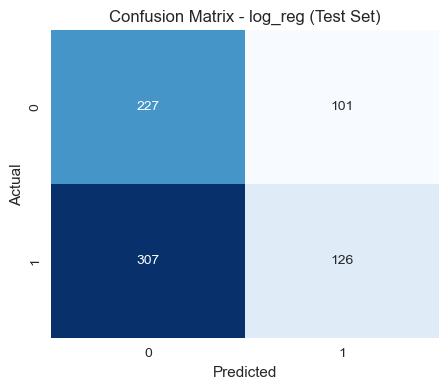

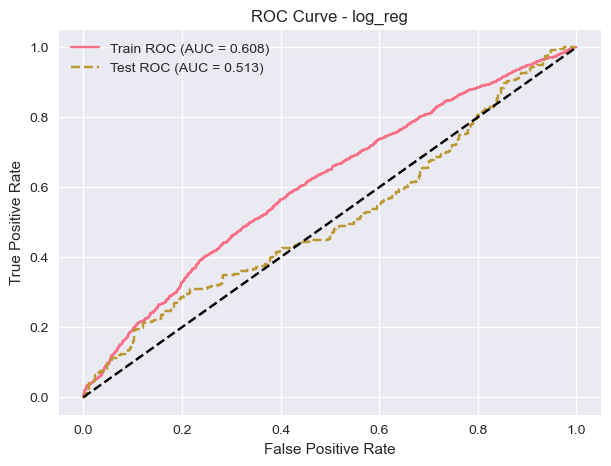

In [87]:
# Confusion Matrix on test set
cm = confusion_matrix(y_test_final, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curves for Train and Test
fpr_train, tpr_train, _ = roc_curve(y_train_full, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_final, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.3f})', linestyle='--')
plt.plot([0,1], [0,1], 'k--')
plt.title(f'ROC Curve - {best_model_name}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

       Feature  Coefficient  Importance
26         ATR    -0.386380    0.386380
20         RSI     0.331102    0.331102
7        month    -0.289158    0.289158
25    BB_width     0.236972    0.236972
12  open_lag_2     0.216543    0.216543
17        MACD    -0.200598    0.200598
8      quarter     0.198577    0.198577
30         vix     0.193606    0.193606
19   MACD_diff    -0.161737    0.161737
27       sp500     0.159734    0.159734


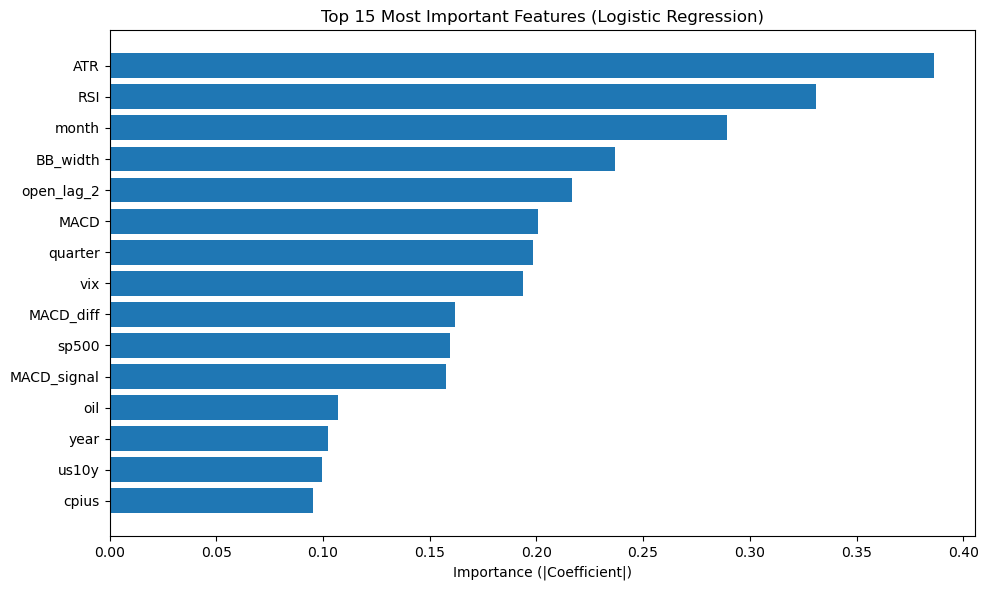

In [26]:
from sklearn.inspection import permutation_importance

# Get coefficients
coefficients = final_model[1].coef_[0]

# Calculate absolute importance
importance = np.abs(coefficients)

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:15][::-1], feature_importance['Importance'][:15][::-1])
plt.xlabel('Importance (|Coefficient|)')
plt.title('Top 15 Most Important Features (Logistic Regression)')
plt.tight_layout()
plt.show()

## Backtesting Strategy

In [ ]:
from math import sqrt

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def expanding_backtest(model, X, y, price_series,
                       min_train_size=252, test_window=21,
                       threshold=0.5, transaction_cost=0.000,
                       position_size=1):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    strategy_returns_all = []

    start = min_train_size
    while start + test_window <= len(X):
        X_train, y_train = X.iloc[:start], y.iloc[:start]
        X_test, y_test = X.iloc[start:start+test_window], y.iloc[start:start+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        # Trading signals
        signals = pd.Series(y_pred, index=X_test.index).shift(1).fillna(0)
        returns = price_series.pct_change().loc[X_test.index].fillna(0)

        raw_returns = signals * returns * position_size
        trades = signals.diff().abs().fillna(0)
        strategy_returns = raw_returns - trades * transaction_cost

        strategy_returns_all.append(strategy_returns)

        start += test_window

    strategy_returns_all = pd.concat(strategy_returns_all)
    cumulative = (1 + strategy_returns_all).cumprod()

    mean_ret = strategy_returns_all.mean()
    std_ret = strategy_returns_all.std()
    downside_std = strategy_returns_all[strategy_returns_all < 0].std()

    return {
        'AUC': roc_auc_score(all_y_true, all_y_proba),
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret != 0 else 0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std != 0 else 0,
        'Max Drawdown': max_drawdown(cumulative),
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, strategy_returns_all


def rolling_backtest(model, X, y, price_series,
                     train_window=252, test_window=21,
                     threshold=0.5, transaction_cost=0.000,
                     position_size=1.0):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    strategy_returns_all = []

    start = 0
    while start + train_window + test_window <= len(X):
        X_train, y_train = X.iloc[start:start+train_window], y.iloc[start:start+train_window]
        X_test, y_test = X.iloc[start+train_window:start+train_window+test_window], y.iloc[start+train_window:start+train_window+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        signals = pd.Series(y_pred, index=X_test.index).shift(1).fillna(0)
        returns = price_series.pct_change().loc[X_test.index].fillna(0)

        raw_returns = signals * returns * position_size
        trades = signals.diff().abs().fillna(0)
        strategy_returns = raw_returns - trades * transaction_cost

        strategy_returns_all.append(strategy_returns)

        start += test_window

    strategy_returns_all = pd.concat(strategy_returns_all)
    cumulative = (1 + strategy_returns_all).cumprod()

    mean_ret = strategy_returns_all.mean()
    std_ret = strategy_returns_all.std()
    downside_std = strategy_returns_all[strategy_returns_all < 0].std()

    return {
        'AUC': roc_auc_score(all_y_true, all_y_proba),
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret != 0 else 0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std != 0 else 0,
        'Max Drawdown': max_drawdown(cumulative),
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, strategy_returns_all

def buy_and_hold_metrics(price_series):
    returns = price_series.pct_change().dropna()
    cumulative = (1 + returns).cumprod()
    
    mean_ret = returns.mean()
    std_ret = returns.std()
    downside_std = returns[returns < 0].std()
    
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else 0
    sortino = (mean_ret / downside_std) * np.sqrt(252) if downside_std != 0 else 0
    mdd = max_drawdown(cumulative)
    
    return {
        'AUC': np.nan,  # not applicable
        'Accuracy': np.nan,  # not applicable
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max Drawdown': mdd,
        'Cumulative Return': cumulative.iloc[-1] - 1
    }, returns

# Run expanding
expanding_results, expanding_returns = expanding_backtest(final_model, X, y, df['price'],
                                       min_train_size=252, test_window=21,
                                       threshold=best_threshold)

# Run rolling for 1-year and 2-year windows
rolling_1yr, rolling_1yr_returns = rolling_backtest(final_model, X, y, df['price'],
                               train_window=252, test_window=21,
                               threshold=best_threshold)

rolling_2yr, rolling_2yr_returns = rolling_backtest(final_model, X, y, df['price'],
                               train_window=504, test_window=21,
                               threshold=best_threshold)

bh_metrics, bh_returns = buy_and_hold_metrics(df['price'])

# Combine into DataFrame
results_df = pd.DataFrame([
    {'Type': 'Expanding', **expanding_results},
    {'Type': 'Rolling 1yr', **rolling_1yr},
    {'Type': 'Rolling 2yr', **rolling_2yr},
    {'Type': 'Buy & Hold', **bh_metrics}
])

print("Backtesting Comparison:")
print(results_df)

Backtesting Comparison:
          Type       AUC  Accuracy    Sharpe   Sortino  Max Drawdown  \
0    Expanding  0.526379  0.538676  0.835671  1.004031     -0.343133   
1  Rolling 1yr  0.521445  0.534727  0.599427  0.655424     -0.341400   
2  Rolling 2yr  0.533004  0.533679  0.488804  0.556466     -0.394775   
3   Buy & Hold       NaN       NaN  0.621998  0.831340     -0.445214   

   Cumulative Return  
0           6.382490  
1           2.765185  
2           1.746519  
3           4.873860  


Backtesting Comparison:
          Type       AUC  Accuracy    Sharpe   Sortino  Max Drawdown  \
0    Expanding  0.526379  0.538676  0.598983  0.803850     -0.403439   
1  Rolling 1yr  0.521445  0.534727  0.617946  0.828085     -0.378959   
2  Rolling 2yr  0.533004  0.533679  0.537543  0.718022     -0.422584   
3   Buy & Hold       NaN       NaN  0.621998  0.831340     -0.445214   

   Cumulative Return  Final Equity  
0           3.448619    440.135117  
1           3.606545    455.759921  
2           2.361057    342.069030  
3           4.898680    587.386045  


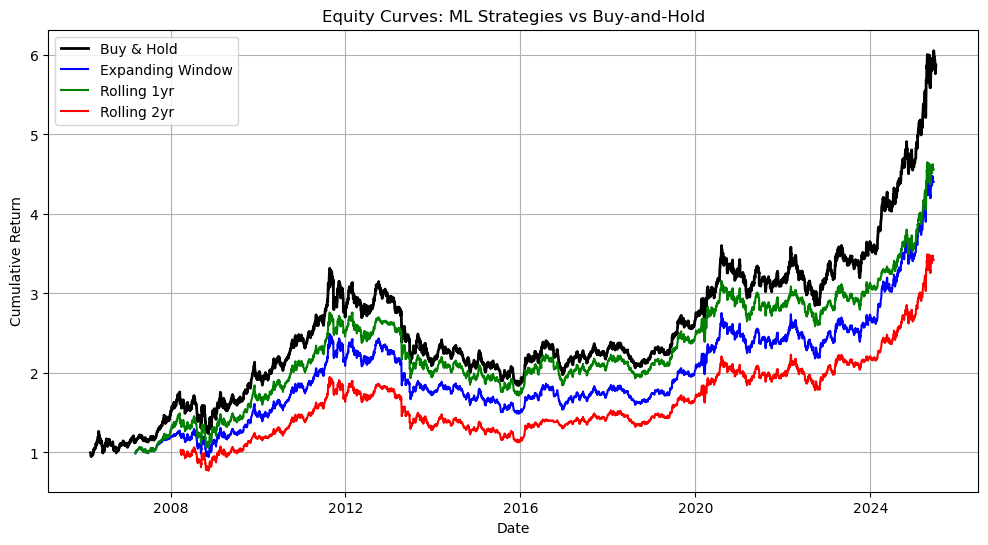

In [43]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import roc_auc_score, accuracy_score

def max_drawdown(equity_series):
    peak = equity_series.cummax()
    dd = (equity_series - peak) / peak
    return dd.min()

def _apply_incremental_allocation(y_idx, y_pred, price_series,
                                  step=0.01, start_weight=1.0,
                                  start_equity=100.0,
                                  transaction_cost=0.000):
    """
    Build daily weights and portfolio returns from binary predictions.
    - If pred==1 -> w_t = min(1, w_{t-1} + step)
    - If pred==0 -> w_t = max(0, w_{t-1} - step)
    Return for day t uses w_{t-1}; cost charged on turnover |w_t - w_{t-1}|.
    """
    rets = price_series.pct_change().reindex(y_idx).fillna(0.0)

    w_prev = start_weight
    weights, turns, port_rets = [], [], []

    for date, sig in zip(y_idx, y_pred):
        # set next weight
        if sig == 1:
            w_t = min(1.0, w_prev + step)
        else:
            w_t = max(0.0, w_prev - step)

        turnover = abs(w_t - w_prev)
        cost = transaction_cost * turnover

        # earn today's return with w_prev
        pr = w_prev * rets.loc[date] - cost

        weights.append(w_t)
        turns.append(turnover)
        port_rets.append(pr)

        w_prev = w_t

    out = pd.DataFrame({'ret': port_rets, 'w': weights, 'turnover': turns}, index=y_idx)
    out['equity'] = start_equity * (1.0 + out['ret']).cumprod()
    return out, w_prev

def expanding_backtest(model, X, y, price_series,
                       min_train_size=252, test_window=21,
                       threshold=0.5, transaction_cost=0.000,
                       step=0.01, start_weight=1.0, start_equity=100.0):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    port_chunks = []
    start = min_train_size
    w_prev = start_weight  # carry weight across windows

    while start + test_window <= len(X):
        X_train, y_train = X.iloc[:start], y.iloc[:start]
        X_test,  y_test  = X.iloc[start:start+test_window], y.iloc[start:start+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred  = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test.values)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        block, w_prev = _apply_incremental_allocation(
            y_idx=X_test.index,
            y_pred=y_pred,
            price_series=price_series,
            step=step,
            start_weight=w_prev,          # continue from previous block
            start_equity=port_chunks[-1]['equity'].iloc[-1] if port_chunks else start_equity,
            transaction_cost=transaction_cost
        )
        port_chunks.append(block)
        start += test_window

    port = pd.concat(port_chunks).sort_index()
    eq = port['equity']
    pr = port['ret']
    mean_ret, std_ret = pr.mean(), pr.std()
    downside_std = pr[pr < 0].std()

    results = {
        'AUC': roc_auc_score(all_y_true, all_y_proba) if len(set(all_y_true)) > 1 else np.nan,
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret else 0.0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std else 0.0,
        'Max Drawdown': max_drawdown(eq),
        'Cumulative Return': eq.iloc[-1] / eq.iloc[0] - 1.0,
        'Final Equity': eq.iloc[-1]
    }
    return results, port['ret']

def rolling_backtest(model, X, y, price_series,
                     train_window=252, test_window=21,
                     threshold=0.5, transaction_cost=0.000,
                     step=0.01, start_weight=1.0, start_equity=100.0):
    all_y_true, all_y_proba, all_y_pred = [], [], []
    port_chunks = []
    start = 0
    w_prev = start_weight

    while start + train_window + test_window <= len(X):
        X_train = X.iloc[start:start+train_window]
        y_train = y.iloc[start:start+train_window]
        X_test  = X.iloc[start+train_window:start+train_window+test_window]
        y_test  = y.iloc[start+train_window:start+train_window+test_window]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred  = (y_proba >= threshold).astype(int)

        all_y_true.extend(y_test.values)
        all_y_proba.extend(y_proba)
        all_y_pred.extend(y_pred)

        block, w_prev = _apply_incremental_allocation(
            y_idx=X_test.index,
            y_pred=y_pred,
            price_series=price_series,
            step=step,
            start_weight=w_prev,
            start_equity=port_chunks[-1]['equity'].iloc[-1] if port_chunks else start_equity,
            transaction_cost=transaction_cost
        )
        port_chunks.append(block)
        start += test_window

    port = pd.concat(port_chunks).sort_index()
    eq = port['equity']
    pr = port['ret']
    mean_ret, std_ret = pr.mean(), pr.std()
    downside_std = pr[pr < 0].std()

    results = {
        'AUC': roc_auc_score(all_y_true, all_y_proba) if len(set(all_y_true)) > 1 else np.nan,
        'Accuracy': accuracy_score(all_y_true, all_y_pred),
        'Sharpe': (mean_ret / std_ret) * sqrt(252) if std_ret else 0.0,
        'Sortino': (mean_ret / downside_std) * sqrt(252) if downside_std else 0.0,
        'Max Drawdown': max_drawdown(eq),
        'Cumulative Return': eq.iloc[-1] / eq.iloc[0] - 1.0,
        'Final Equity': eq.iloc[-1]
    }
    return results, port['ret']

def buy_and_hold_metrics(price_series, start_equity=100.0):
    rets = price_series.pct_change().dropna()
    eq = start_equity * (1 + rets).cumprod()
    mean_ret, std_ret = rets.mean(), rets.std()
    downside_std = rets[rets < 0].std()

    return {
        'AUC': np.nan,
        'Accuracy': np.nan,
        'Sharpe': (mean_ret / std_ret) * np.sqrt(252) if std_ret else 0.0,
        'Sortino': (mean_ret / downside_std) * np.sqrt(252) if downside_std else 0.0,
        'Max Drawdown': max_drawdown(eq),
        'Cumulative Return': eq.iloc[-1] / eq.iloc[0] - 1.0,
        'Final Equity': eq.iloc[-1]
    }, rets

# --- Run backtests (example) ---
# expanding
expanding_results, expanding_returns = expanding_backtest(
    final_model, X, y, df['price'],
    min_train_size=252, test_window=21,
    threshold=best_threshold, transaction_cost=0.001,
    step=0.01, start_weight=1.0, start_equity=100.0
)

# rolling 1yr
rolling_1yr, rolling_1yr_returns = rolling_backtest(
    final_model, X, y, df['price'],
    train_window=252, test_window=21,
    threshold=best_threshold, transaction_cost=0.001,
    step=0.01, start_weight=1.0, start_equity=100.0
)

# rolling 2yr
rolling_2yr, rolling_2yr_returns = rolling_backtest(
    final_model, X, y, df['price'],
    train_window=504, test_window=21,
    threshold=best_threshold, transaction_cost=0.001,
    step=0.01, start_weight=1.0, start_equity=100.0
)

# buy & hold
bh_metrics, bh_returns = buy_and_hold_metrics(df['price'], start_equity=100.0)

# summary
results_df = pd.DataFrame([
    {'Type': 'Expanding', **expanding_results},
    {'Type': 'Rolling 1yr', **rolling_1yr},
    {'Type': 'Rolling 2yr', **rolling_2yr},
    {'Type': 'Buy & Hold', **bh_metrics}
])

print("Backtesting Comparison:")
print(results_df)

plot_equity_curves(df['price'], expanding_returns, rolling_1yr_returns, rolling_2yr_returns)

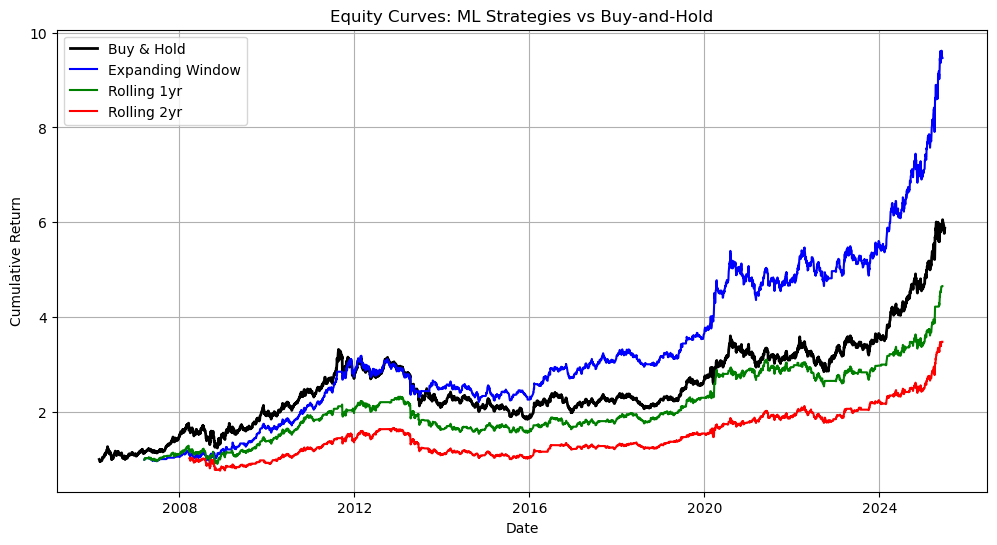

In [39]:
def plot_equity_curves(price_series, expanding_returns, rolling1_returns, rolling2_returns):
    # Compute cumulative equity curves
    bh_equity = (1 + price_series.pct_change().dropna()).cumprod()
    expanding_equity = (1 + expanding_returns).cumprod()
    rolling1_equity = (1 + rolling1_returns).cumprod()
    rolling2_equity = (1 + rolling2_returns).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(bh_equity.index, bh_equity, label='Buy & Hold', color='black', linewidth=2)
    plt.plot(expanding_equity.index, expanding_equity, label='Expanding Window', color='blue')
    plt.plot(rolling1_equity.index, rolling1_equity, label='Rolling 1yr', color='green')
    plt.plot(rolling2_equity.index, rolling2_equity, label='Rolling 2yr', color='red')

    plt.title('Equity Curves: ML Strategies vs Buy-and-Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_equity_curves(df['price'], expanding_returns, rolling_1yr_returns, rolling_2yr_returns)